In [1]:
import astropy.units as u
from astropy.constants import k_B, m_e, m_p, h, R_sun, c
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.stats import chisquare
from itertools import product


# Q1

### Import data and plot

In [2]:
data = pd.read_csv("firas_monopole_spec_v1.txt", comment="#", delim_whitespace=True, names=['freq', 'spec', 'resid', 'unc', 'model'])

<AxesSubplot:xlabel='freq'>

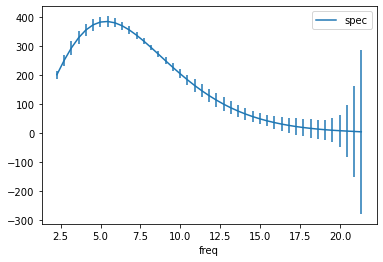

In [3]:
# error bars are 1000 sigma
data.plot('freq', 'spec', yerr='unc')

In [4]:
def planck_w_mu_unitless(nu, mu, T):
    # returns energy MJy / Sr
    nu_ = c.cgs.value * nu
    return (2 * h.cgs.value * nu_ ** 3 / c.cgs.value ** 2 * 1 / (np.exp((h.cgs.value * nu_ - mu) / (k_B.cgs.value * T)) - 1)) / 1e-17   # convert to MJy

In [5]:
def chi2(exp, obs, unc, ddof=2):
    # finds the chi2 statistic
    return (((exp-obs)/unc) ** 2 ).sum()

In [6]:
Ts = np.linspace(2.7249, 2.7251, 201)
mus = np.linspace(0, 5e-20, 201)
grid = np.meshgrid(Ts, mus)

params = list(product(Ts, mus))

In [7]:
chi2s = []
for T, mu in params:
    chi2s.append(chi2(planck_w_mu_unitless(data['freq'], mu, T), data['spec'], data['unc']/1e3))
chi2s = pd.DataFrame(np.array(chi2s).reshape(201,201), index=Ts, columns=mus).T

In [8]:
dchi2s = chi2s - chi2s.min().min()

### Plot $\chi^2$ contours and 1, 2, 3 $\sigma$ levels

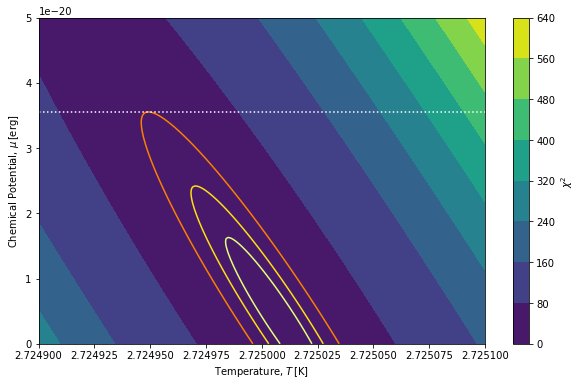

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches((10,6))
contour = ax.contourf(Ts, mus, chi2s)
plt.colorbar(contour, ax=ax, label=r"$\chi^2$")
ax.contour(Ts, mus, dchi2s, levels=np.array([1, 2.71, 6.63]), cmap='Wistia') # levels for 1, 2, 3 sigma 
plt.axhline(3.55e-20, color='white', ls=':') # maximum mu within 3 sigma -- spoilers!
ax.set_xlabel(r"Temperature, $T \, [\rm K]$")
ax.set_ylabel(r"Chemical Potential, $\mu \, [\rm erg]$")
plt.show()

### Find max mu for all $\chi^2$ within 6.63 of $\chi^2_{min}$

In [10]:
min_chi2 = chi2s.min().min()

In [11]:
chi_thres = 6.63
mu_is_within_thres = ((chi2s - chi2s.min().min()) < chi_thres).sum(axis=1) > 0
mu_is_within_thres[mu_is_within_thres].index.max()

3.55e-20

### Get corresponding T

In [12]:
T_355 = (chi2s.loc[3.55e-20] - min_chi2) < chi_thres

In [13]:
T_355[T_355]

2.724949    True
2.724950    True
Name: 3.55e-20, dtype: bool

### Find $\frac{\mu_{max}}{k_B T}$

In [14]:
(mu_is_within_thres[mu_is_within_thres].index.max()*u.erg / (k_B * 2.725 * u.K)).cgs

<Quantity 9.43579645e-05>

# Q3

In [15]:
T = 6 * 10 ** 6 * u.K
rho_c = 325 * u.g * u.cm ** -3
s = 1 / 2

In [16]:
lmb = h / (2 * np.pi * m_e * k_B * T) ** (1/2)
lmb.cgs

<Quantity 3.04301667e-09 cm>

In [17]:
from scipy.special import gamma

# writen by Tom to calculate the Fermi Dirac Function for 1/2 and 3/2
def fermi_dirac(j, z):
    assert j in [0.5, 1.5]
    
    if j == 0.5:
        a = 9.6
        b = 2.13
        c = 12 / 5
    else:
        a = 14.9
        b = 2.64
        c = 9 / 4
        
    first_term = (j + 1) * 2**(j + 1) / (b + z + (np.abs(z - b)**c + a)**(1/c))**(j + 1)
    second_term = np.exp(-z) / gamma(j + 1)
    
    return (first_term + second_term)**(-1) 

In [18]:
n_e = 6/7 * rho_c / m_p

In [19]:
n_e.cgs

<Quantity 1.66547756e+26 1 / cm3>

In [20]:
val = (np.sqrt(np.pi) * lmb ** 3 / (2 * (2 * s + 1)) * n_e).cgs.value

In [21]:
def solve_for_z(val, dec=3):
    xs = np.linspace(1, 2, 100)
    dd = 0
    value = 0
    while dd < dec:
        ind = np.argmin(abs(fermi_dirac(.5, xs) - val))
        value = xs[ind]
        xs = np.linspace(xs[ind-1], xs[ind+1], 100)
        dd += 1
        
    return round(value, dec)
    

In [25]:
z = solve_for_z(val, 5)
z

1.65008

### b


In [23]:
P  = (4 * (2 * s + 1) / (3 * np.pi ** 0.5 * lmb ** 3) * fermi_dirac(3/2, z) * k_B * T).cgs
P

<Quantity 1.92126677e+17 P / s>

### d

In [27]:
P_ig = (n_e * k_B * T).to(u.P/u.s)

In [28]:
P_ig

<Quantity 1.37966396e+17 P / s>

In [29]:
del_P = P - P_ig

In [30]:
del_P / P

<Quantity 0.28189881>

In [31]:
help(u.P)

Help on Unit in module astropy.units.core:

Unit("P")
    poise: CGS unit of dynamic viscosity



### e

In [32]:
u_e = 1.1

In [33]:
R  = ((0.13 / (u_e * fermi_dirac(1/2, z)) ** (2/3)) * (rho_c / (8.44 * u.g * u.cm ** -3)) ** (- 1/3)) ** (1/2)

In [34]:
M = (rho_c * R ** 3 / (8.44 * u.g * u.cm**-3))

In [35]:
R

<Quantity 0.14891156>

In [36]:
M

<Quantity 0.12715286>